# Predict fuel efficiency

In [192]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [193]:
# Make the numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

## Auto MPG dataset

### Data Preprocessing

In [194]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = [
    "MPG",
    "Cylinders",
    "Displacement",
    "Horsepower",
    "Weight",
    "Acceleration",
    "Model Year",
    "Origin",
]

raw_dataset = pd.read_csv(
    url, names=column_names, na_values="?", comment="\t", sep=" ", skipinitialspace=True
)

In [195]:
ds = raw_dataset.copy()
ds.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


#### Clean the data

In [196]:
ds.isna().sum()  # missing data check

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [197]:
ds = ds.dropna()  # drop missing values

In [198]:
ds["Origin"] = ds["Origin"].map({1: "USA", 2: "Europe", 3: "Japan"})

In [199]:
ds = pd.get_dummies(
    ds,
    columns=["Origin"],
    prefix="",
    prefix_sep="",
)
ds.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


#### Train test split

In [200]:
# Train test split
train_ds = ds.sample(frac=0.8, random_state=12)  # Train set
test_ds = ds.drop(train_ds.index)  # Test set

#### Inspect data

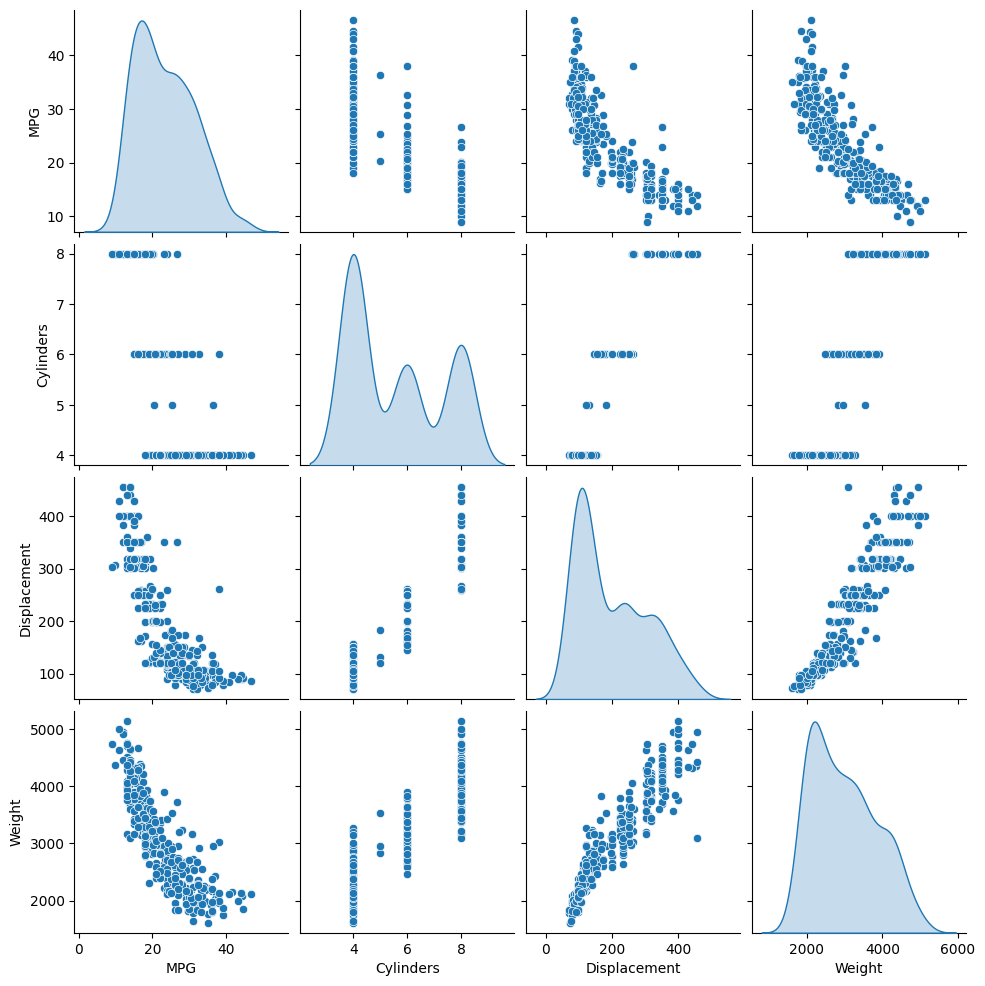

In [201]:
sns.pairplot(train_ds[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")
plt.show()

In [202]:
train_ds.describe().transpose()  # statistics

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.444586,7.913691,9.0,17.00,22.15,29.375,46.6
Cylinders,314.0,5.576433,1.698210,4.0,4.00,6.00,8.000,8.0
Displacement,314.0,200.246815,106.369828,71.0,105.00,156.00,302.000,455.0
Horsepower,314.0,105.117834,38.879951,46.0,76.00,95.00,130.000,230.0
Weight,314.0,2997.808917,856.314102,1613.0,2219.25,2900.50,3618.250,5140.0
Acceleration,314.0,15.488854,2.805364,8.0,13.50,15.50,17.000,24.8
Model Year,314.0,75.987261,3.777328,70.0,73.00,76.00,79.000,82.0


#### Split features from labels

In [203]:
train_features = train_ds.copy()
test_features = test_ds.copy()

train_labels = train_features.pop("MPG")
test_labels = test_features.pop("MPG")

In [204]:
train_features.tail()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
391,4,135.0,84.0,2370.0,13.0,82,False,False,True
346,4,97.0,67.0,2065.0,17.8,81,False,True,False
378,4,105.0,63.0,2125.0,14.7,82,False,False,True
92,8,351.0,158.0,4363.0,13.0,73,False,False,True
115,8,350.0,145.0,4082.0,13.0,73,False,False,True


In [205]:
test_features.tail()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
362,6,146.0,120.0,2930.0,13.8,81,False,True,False
365,6,200.0,88.0,3060.0,17.1,81,False,False,True
369,4,112.0,88.0,2395.0,18.0,82,False,False,True
379,4,98.0,70.0,2125.0,17.3,82,False,False,True
393,4,140.0,86.0,2790.0,15.6,82,False,False,True


##### Normalization

In [206]:
train_ds.describe().transpose()[["mean", "std"]]

,mean,std
MPG,23.444586,7.913691
Cylinders,5.576433,1.698210
Displacement,200.246815,106.369828
Horsepower,105.117834,38.879951
Weight,2997.808917,856.314102
Acceleration,15.488854,2.805364
Model Year,75.987261,3.777328


In [207]:
normalizer = tf.keras.layers.Normalization(axis=-1)  # create normalization layer

normalizer.adapt(
    np.array(train_features)
)  # fit the state of preprocessing layer to the data

print(normalizer.mean.numpy())  # calc the mean and variance

[[   5.576  200.247  105.118 2997.809   15.489   75.987    0.156    0.204
     0.64 ]]


In [208]:
first = np.array(train_features[:1], dtype=float)

with np.printoptions(precision=2, suppress=True):
    print("First example:", first)
    print()
    print("Normalized:", normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.93 -1.04 -0.78 -1.02 -0.35 -0.53 -0.43 -0.51  0.75]]


In [209]:
train_features.Horsepower.tail()

391     84.0
346     67.0
378     63.0
92     158.0
115    145.0
Name: Horsepower, dtype: float64

### Linear regression

#### Linear regression with one variable

In [210]:
horsepower = np.array(train_features["Horsepower"])
print(horsepower[-5:])
print()

horsepower_normalizer = tf.keras.layers.Normalization(
    input_shape=[
        1,
    ],
    axis=None,
)
horsepower_normalizer.adapt(horsepower)

[ 84.  67.  63. 158. 145.]



/Users/isaacadoboe/miniconda3/envs/deep/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [211]:
horsepower_model = tf.keras.Sequential(
    [horsepower_normalizer, tf.keras.layers.Dense(units=1)]
)  # define and build model architecture

horsepower_model.summary()  # print summary

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_9 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

In [212]:
horsepower_model.predict(horsepower[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([[ 1.241],
       [ 1.118],
       [ 0.335],
       [-2.468],
       [ 1.859],
       [ 1.406],
       [ 0.293],
       [ 0.417],
       [ 1.736],
       [ 1.571]], dtype=float32)

In [213]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mean_absolute_error"
)

In [214]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 4.51 s, sys: 373 ms, total: 4.88 s
Wall time: 4.49 s


In [215]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.894137,3.989063,95
96,3.894312,3.983595,96
97,3.893964,3.985192,97
98,3.894387,3.982583,98
99,3.893847,3.979405,99


In [239]:
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.ylim([0, 20])
    plt.xlabel("Epoch")
    plt.ylabel("Error [MPG]")
    plt.legend()
    plt.grid(True)

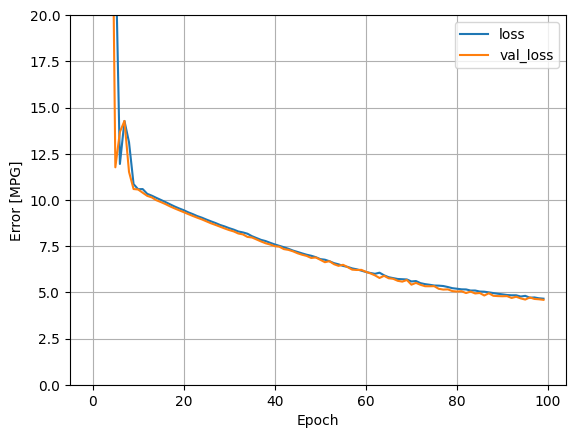

In [240]:
plot_loss(history)

In [241]:
test_results = {}

test_results["horsepower_model"] = horsepower_model.evaluate(
    test_features["Horsepower"], test_labels, verbose=0
)

In [242]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [243]:
def plot_horsepower(x, y):
    plt.scatter(train_features["Horsepower"], train_labels, label="Data")
    plt.plot(x, y, color="k", label="Predictions")
    plt.xlabel("Horsepower")
    plt.ylabel("MPG")
    plt.legend()

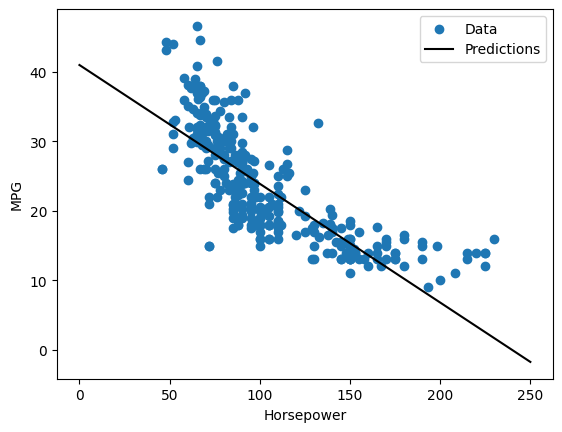

In [244]:
plot_horsepower(x, y)

#### Using Scikit learn's deterministic linear model

In [245]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

train_hp = np.array(train_features["Horsepower"]).reshape(-1, 1)
test_hp = np.array(test_features["Horsepower"]).reshape(-1, 1)

std_scaler = StandardScaler()
train_features_hp_std = std_scaler.fit_transform(train_hp)
test_features_hp_std = std_scaler.transform(test_hp)

lm_model = LinearRegression()
lm_model.fit(train_features_hp_std, train_labels)

predictions = lm_model.predict(train_features_hp_std[:10])
predictions

array([28.186, 27.714, 24.723, 14.017, 30.548, 28.816, 24.565, 25.037,
       30.075, 29.446])

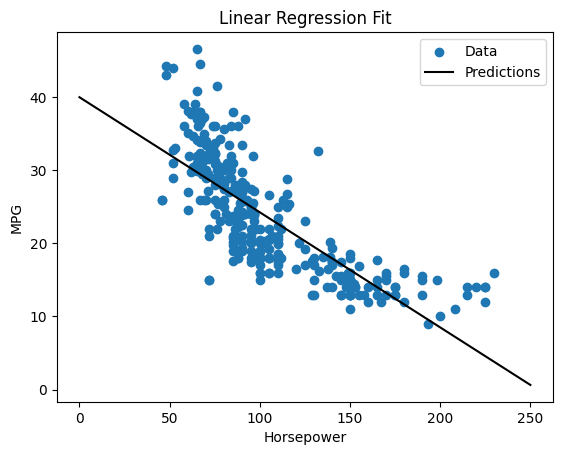

In [246]:
# Standardize x values before prediction
x = np.linspace(0.0, 250, 251).reshape(-1, 1)
x_std = std_scaler.transform(x)  # Use the same scaler to transform x

# Get predictions using the standardized x
y = lm_model.predict(x_std)

# Plot the data and the regression line
# plt.figure(figsize=(10, 6))
plt.scatter(train_features["Horsepower"], train_labels, label="Data")
plt.plot(x, y, color="k", label="Predictions")
plt.xlabel("Horsepower")
plt.ylabel("MPG")
plt.title("Linear Regression Fit")
plt.legend()
plt.show()

It's simple but not the same.

#### Linear regression with multiple inputs

In [247]:
linear_model = tf.keras.Sequential([normalizer, tf.keras.layers.Dense(units=1)])

In [248]:
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


array([[ 0.639],
       [ 1.986],
       [-2.001],
       [-2.084],
       [-0.751],
       [ 1.554],
       [ 1.783],
       [-1.359],
       [ 1.373],
       [-0.828]], dtype=float32)

In [249]:
linear_model.layers[
    1
].kernel  # check the kernel weights (the m in y=mx+b) have shape (9,1)

<Variable path=sequential_5/dense_7/kernel, shape=(9, 1), dtype=float32, value=[[-0.768]
 [ 0.132]
 [ 0.039]
 [-0.169]
 [ 0.595]
 [ 0.355]
 [ 0.662]
 [-0.71 ]
 [ 0.323]]>

In [250]:
linear_model.compile(optimizer="adam", loss="mae")

In [251]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split = 0.2)

CPU times: user 4.77 s, sys: 467 ms, total: 5.24 s
Wall time: 5.02 s


In [252]:
hist = pd.DataFrame(history.history)
hist.tail()

,loss,val_loss
95,22.682602,22.671833
96,22.674545,22.664133
97,22.666332,22.656624
98,22.658318,22.649204
99,22.650286,22.641497


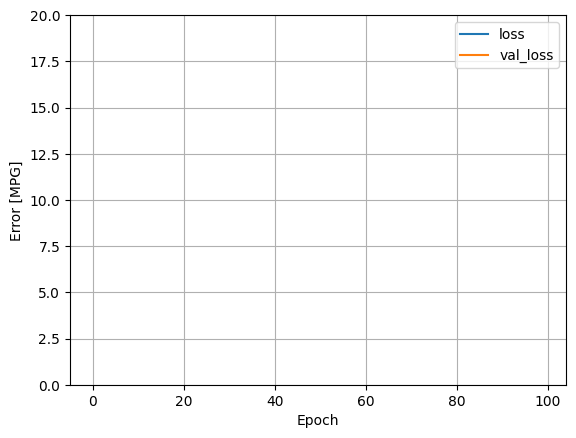

In [253]:
plot_loss(history)

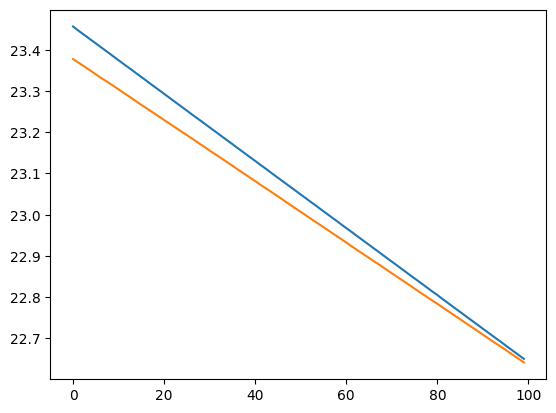

In [254]:
plt.plot(hist.loss)
plt.plot(hist.val_loss)

### Regression with deep neural network (DNN)

In [255]:
def build_and_compile_model(norm):
    model = tf.keras.Sequential(
        [
            norm,
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(1),
        ]
    )

    model.compile(loss="mae", optimizer="adam")

    return model

In [256]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [257]:
dnn_horsepower_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_9 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

In [258]:
%%time
history = linear_model.fit(
    train_features["Horsepower"],
    train_labels,
    epochs=100,
    verbose=0,
    validation_split = 0.2)

CPU times: user 4.42 s, sys: 389 ms, total: 4.8 s
Wall time: 4.43 s


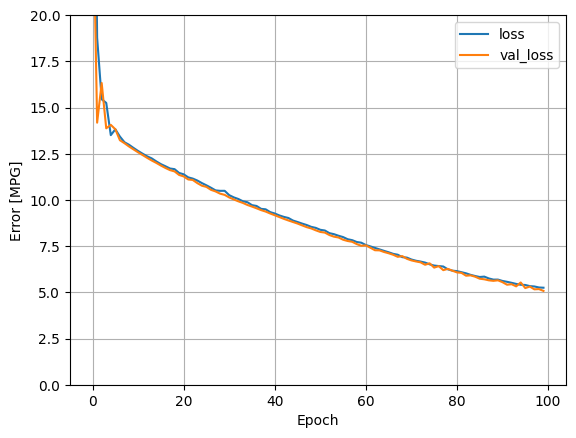

In [259]:
plot_loss(history)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


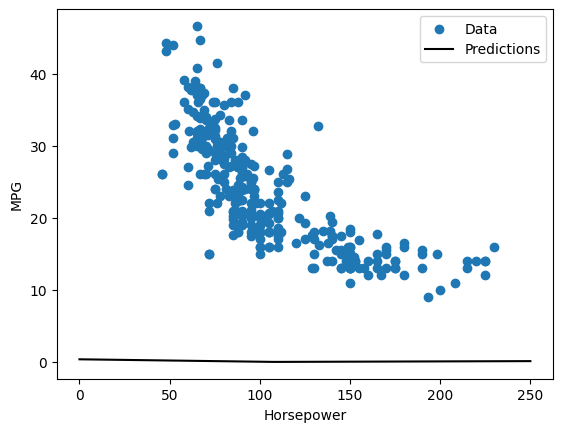

In [260]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

plot_horsepower(x, y)

In [ ]:
test_results["dnn_horsepower_model"] = dnn_horsepower_model.evaluate(
    test_features["Horsepower"], test_labels, verbose=0
)

#### Regression using DNN and multiple inputs

In [262]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_8 (Normalization) │ (10, 9)                │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [263]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    epochs = 100,
    verbose = 0,
    validation_split = 0.2
)

CPU times: user 4.69 s, sys: 442 ms, total: 5.14 s
Wall time: 4.67 s


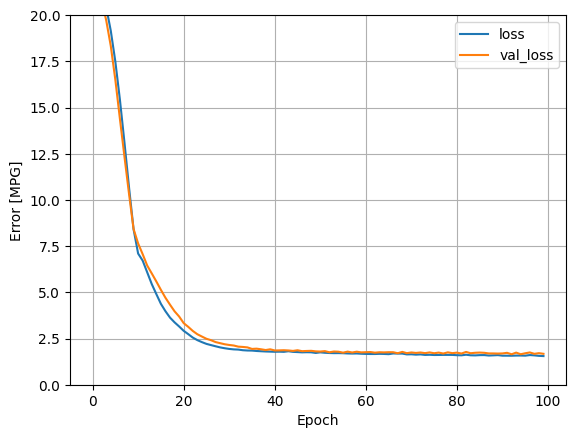

In [264]:
plot_loss(history)

In [265]:
test_results["dnn_model"] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

In [273]:
pd.DataFrame(test_results, index=["Mean absolute error [MPG]"]).T

,Mean absolute error [MPG]
horsepower_model,3.423604
dnn_horsepower_model,23.385763
dnn_model,2.186156


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


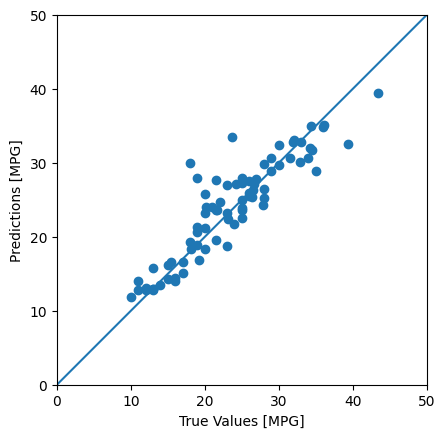

In [269]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

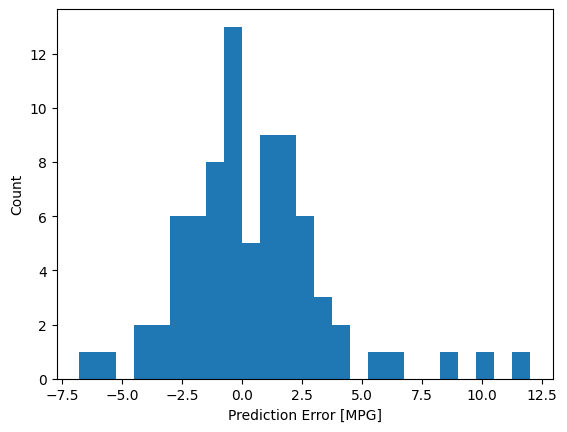

In [270]:
# Error distribution
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')